                     120m
Date/Time                
2020-01-01 00:00:00  3.25
2020-01-01 01:00:00  4.96
2020-01-01 02:00:00  5.55
2020-01-01 03:00:00  5.08
2020-01-01 04:00:00  4.86
               120m
count  26304.000000
mean       3.082705
std        2.182042
min        0.020000
25%        1.510000
50%        2.570000
75%        4.260000
max       19.320000
120m    0
dtype: int64


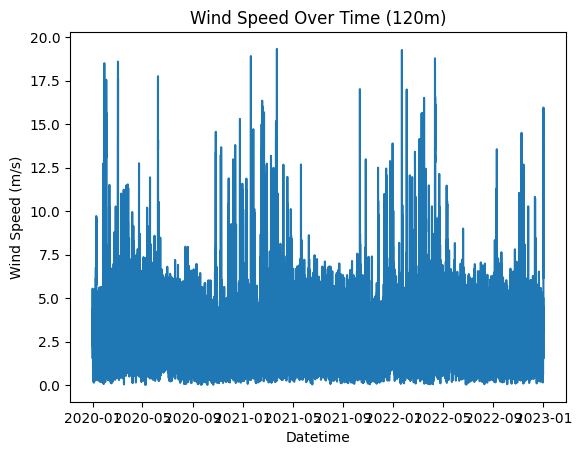

Train size: 18412
Validation size: 3946
Test size: 3946
Train shapes: (18388, 24, 1) (18388, 1, 1)
Validation shapes: (3922, 24, 1) (3922, 1, 1)
Test shapes: (3922, 24, 1) (3922, 1, 1)
Scaled shapes: (18388, 24, 1) (18388, 1, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 300)            │         9,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,284 (540.17 KB)

 Trainable params: 138,284 (540.17 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: -0.0155 - val_loss: -0.8373
Epoch 2/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: -0.9222 - val_loss: -0.7867
Epoch 3/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: -0.9743 - val_loss: -0.9857
Epoch 4/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: -1.0972 - val_loss: -1.0670
Epoch 5/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: -1.2019 - val_loss: -1.2155
Epoch 6/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: -1.3067 - val_loss: -1.5068
Epoch 7/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: -1.4746 - val_loss: -1.4848
Epoch 8/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: -1.5438 - val_loss: -1.5791
Epoch 9/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: -1.6173 - val_loss: -1.5121
Epoch 10/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: -1.5930 - val_loss: -1.6097
Epoch 11/50
288/288 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: -1.6307 - val_loss: -1.6185
Epoch 12/50

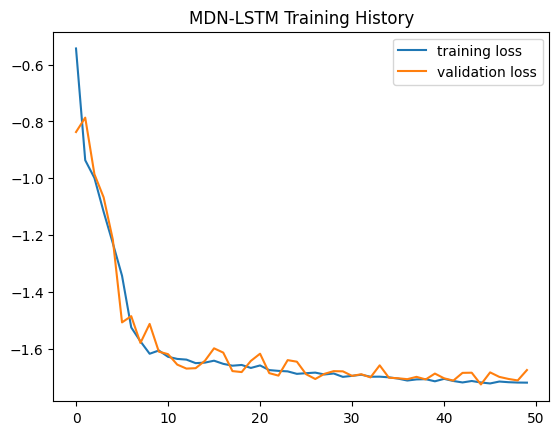

PICP: 0.962
MPIW: 3.526


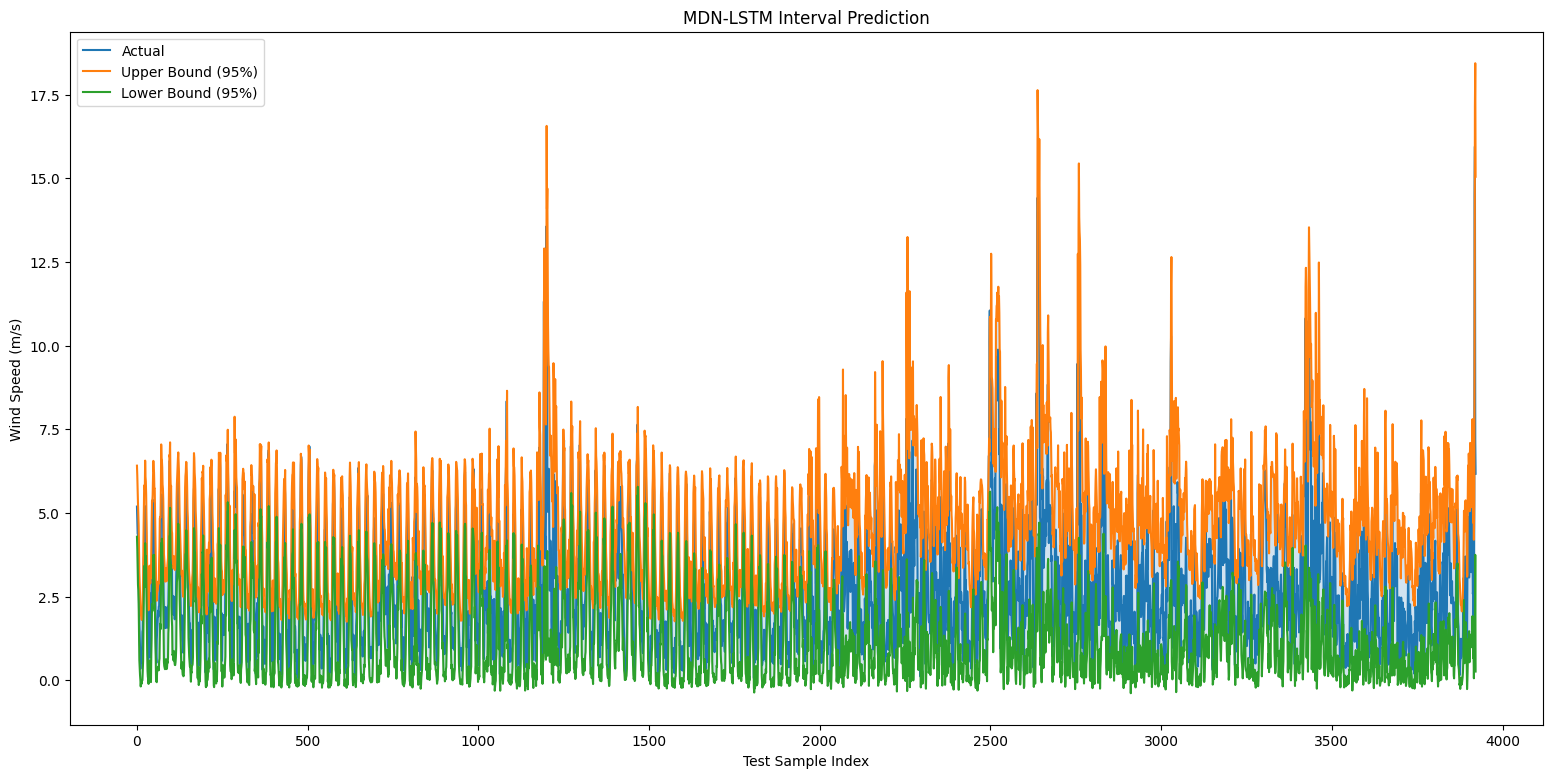

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
import math
import csv
import scipy.stats

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

###############################################################################
# 0) Load & Prepare Data
###############################################################################

# 0.1 Read CSV
df = pd.read_csv(
    r"D:\drive-download-20240928T074710Z-001\Data\los angeles.csv",
    index_col='Date/Time',
    parse_dates=True
)
# dataset = 'Jaisalmer'
# savefilename = 'Jaisalmer.csv'

# 0.2 Filter data if needed, keep only hourly data (minute == 0)
df = df[df.index.minute == 0]

# 0.3 Use only '120m' column, rename or keep
df = pd.DataFrame({'120m': df['120m']}, index=df.index)
print(df.head())

# 0.4 Quick stats & plot
print(df.describe())
print(df.isna().sum())

plt.plot(df)
plt.title('Wind Speed Over Time (120m)')
plt.xlabel('Datetime')
plt.ylabel('Wind Speed (m/s)')
plt.savefig('jaisalmer.png')
plt.show()

# 0.5 Time-based splitting
validation_size = 0.15
test_size = 0.15

split_index_val = int(len(df) * (1 - validation_size - test_size))
split_index_test = int(len(df) * (1 - test_size))

train_data = df[:split_index_val]
validation_data = df[split_index_val:split_index_test]
test_data = df[split_index_test:]

print("Train size:", len(train_data))
print("Validation size:", len(validation_data))
print("Test size:", len(test_data))

###############################################################################
# 1) Truncate Function for (input_window_size, 1) -> next 1
###############################################################################
def truncate(x, feature_cols=range(1), target_cols=range(1),
             label_col=1, train_len=24, test_len=1):
    """
    x: 2D array of shape (num_samples, num_features)
    feature_cols: which columns to treat as inputs
    target_cols: which columns to treat as outputs
    train_len: how many timesteps in the input window
    test_len: how many timesteps to predict
    Returns: (X, Y)
      X.shape = (num_windows, train_len, len(feature_cols))
      Y.shape = (num_windows, test_len, len(target_cols))
    """
    in_, out_ = [], []
    for i in range(len(x) - train_len - test_len + 1):
        in_.append(x[i : i + train_len, feature_cols].tolist())
        out_.append(x[i + train_len : i + train_len + test_len, target_cols].tolist())
    return np.array(in_), np.array(out_)

# 1.1 Prepare your train/val/test arrays
input_window_size = 24  # e.g. 24-hour lookback

train_x, train_y = truncate(train_data.values,
                            feature_cols=range(1),
                            target_cols=range(1),
                            label_col=1,
                            train_len=input_window_size,
                            test_len=1)

val_x, val_y = truncate(validation_data.values,
                        feature_cols=range(1),
                        target_cols=range(1),
                        label_col=1,
                        train_len=input_window_size,
                        test_len=1)

test_x, test_y = truncate(test_data.values,
                          feature_cols=range(1),
                          target_cols=range(1),
                          label_col=1,
                          train_len=input_window_size,
                          test_len=1)

print("Train shapes:", train_x.shape, train_y.shape)
print("Validation shapes:", val_x.shape, val_y.shape)
print("Test shapes:", test_x.shape, test_y.shape)

###############################################################################
# 2) Scaling
###############################################################################
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Flatten to fit, then reshape back
train_x_2d = train_x.reshape(-1, 1)
val_x_2d   = val_x.reshape(-1, 1)
test_x_2d  = test_x.reshape(-1, 1)

scaler_x.fit(train_x_2d)
train_x_scaled = scaler_x.transform(train_x_2d).reshape(train_x.shape)
val_x_scaled   = scaler_x.transform(val_x_2d).reshape(val_x.shape)
test_x_scaled  = scaler_x.transform(test_x_2d).reshape(test_x.shape)

# Targets
train_y_2d = train_y.reshape(-1, 1)
val_y_2d   = val_y.reshape(-1, 1)
test_y_2d  = test_y.reshape(-1, 1)

scaler_y.fit(train_y_2d)
train_y_scaled = scaler_y.transform(train_y_2d).reshape(train_y.shape)
val_y_scaled   = scaler_y.transform(val_y_2d).reshape(val_y.shape)
test_y_scaled  = scaler_y.transform(test_y_2d).reshape(test_y.shape)

print("Scaled shapes:", train_x_scaled.shape, train_y_scaled.shape)

###############################################################################
# 3) MDN Loss & Model
###############################################################################
def mdn_loss(n_components):
    """
    Negative log-likelihood loss for mixture of Gaussians.
    final layer size = 3*n_components => out_pi, out_mu, out_sigma
    """
    def mdn_nll(y_true, y_pred):
        # y_true shape: (batch, 1) if univariate
        y_true = tf.reshape(y_true, [-1, 1])

        # slice out pi, mu, sigma
        out_pi     = y_pred[:, :n_components]                 # (batch, n_components)
        out_mu     = y_pred[:, n_components:2*n_components]   # (batch, n_components)
        out_sigma  = y_pred[:, 2*n_components:]               # (batch, n_components)

        # transform
        pi     = tf.nn.softmax(out_pi, axis=-1)  # sum=1
        sigma  = tf.exp(out_sigma)               # >0

        # compute gaussians
        one_over_sqrt2pi = 1.0 / np.sqrt(2.0 * np.pi)
        norm = one_over_sqrt2pi / sigma
        exponent = -0.5 * tf.square((y_true - out_mu) / sigma)
        gauss = norm * tf.exp(exponent)  # shape (batch, n_components)

        # numerical stability
        mixture_pdf = tf.reduce_sum(pi * gauss, axis=1) + 1e-8
        nll = -tf.math.log(mixture_pdf)
        return tf.reduce_mean(nll)

    return mdn_nll

def create_mdn_lstm(input_shape, hidden_layers=[128], n_components=5, dropout=0.0):
    """
    Builds an LSTM model whose final Dense has 3*n_components outputs => MDN
    """
    x_in = Input(shape=input_shape)
    x = x_in

    for i, units in enumerate(hidden_layers):
        return_seq = (i < len(hidden_layers) - 1)
        x = LSTM(units, activation='relu', return_sequences=return_seq)(x)
        if dropout > 0:
            x = Dropout(dropout)(x)

    out = Dense(3 * n_components)(x)
    model = Model(inputs=x_in, outputs=out)
    return model

###############################################################################
# 4) Train the MDN-LSTM
###############################################################################
n_features = 1  # univariate input
n_components = 100  # Reduced number of components for demonstration
hidden_layers = [128,64,32]
dropout_rate = 0.0

model = create_mdn_lstm(
    input_shape=(input_window_size, n_features),
    hidden_layers=hidden_layers,
    n_components=n_components,
    dropout=dropout_rate
)

model.compile(
    loss=mdn_loss(n_components),
    optimizer=Adam(learning_rate=0.001)
)

model.summary()

epc = 50
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, mode='min'
)

start_time = datetime.datetime.now()

history = model.fit(
    train_x_scaled, train_y_scaled,
    validation_data=(val_x_scaled, val_y_scaled),
    epochs=epc,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)

end_time = datetime.datetime.now()
total_time = (end_time - start_time).total_seconds()
print("Training time:", round(total_time, 2), "seconds")

# Plot training curves
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title("MDN-LSTM Training History")
plt.show()

###############################################################################
# 5) Inference: Predict Mixture & Derive Intervals
###############################################################################

# 5.1 Predict mixture parameters on test set
test_pred = model.predict(test_x_scaled, verbose=0)
# test_pred shape: (num_test, 3*n_components)
out_pi    = test_pred[:, :n_components]
out_mu    = test_pred[:, n_components:2*n_components]
out_sigma = test_pred[:, 2*n_components:]

# Transform them
pi_all    = tf.nn.softmax(out_pi, axis=-1).numpy()  # shape (num_test, n_components)
mu_all    = out_mu                                  # shape (num_test, n_components)
sigma_all = np.exp(out_sigma)                       # shape (num_test, n_components)

# 5.2 Define mixture CDF & quantile bisection
def mixture_cdf(x, pi, mu, sigma):
    """
    Evaluate F_mix(x) = sum_i pi_i * Phi((x - mu_i)/sigma_i).
    """
    return np.sum(pi * scipy.stats.norm.cdf((x - mu) / sigma))

def mixture_quantile(pi, mu, sigma, alpha=0.95, x_low=-5.0, x_high=5.0,  # Adjusted bounds for scaled data
                     tol=1e-4, max_iter=100):
    """
    Bisection for alpha-quantile in univariate mixture in SCALED space.
    """
    for _ in range(max_iter):
        mid = 0.5 * (x_low + x_high)
        cdf_mid = mixture_cdf(mid, pi, mu, sigma)
        if cdf_mid > alpha:
            x_high = mid
        else:
            x_low = mid
        if (x_high - x_low) < tol:
            break
    return 0.5 * (x_low + x_high)

def get_interval_from_mixture(pi_row, mu_row, sigma_row, alpha_interval=0.95):
    """
    Calculates the prediction interval using the mixture parameters.
    Bisection is performed in the scaled space and then inverted.
    """
    lower_alpha = 0.5 * (1 - alpha_interval)
    upper_alpha = 1.0 - lower_alpha

    def mixture_cdf_scaled(z):
        return np.sum(pi_row * scipy.stats.norm.cdf((z - mu_row) / sigma_row))

    def mixture_quantile_scaled(alpha, z_low=-5.0, z_high=5.0, tol=1e-4, max_iter=100): # Adjusted bounds
        for _ in range(max_iter):
            mid = 0.5 * (z_low + z_high)
            cdf_mid = mixture_cdf_scaled(mid)
            if cdf_mid > alpha:
                z_high = mid
            else:
                z_low = mid
            if (z_high - z_low) < tol:
                break
        return 0.5 * (z_low + z_high)

    z_low_scaled = mixture_quantile_scaled(lower_alpha)
    z_high_scaled = mixture_quantile_scaled(upper_alpha)

    q_low  = scaler_y.inverse_transform([[z_low_scaled]])[0,0]
    q_high = scaler_y.inverse_transform([[z_high_scaled]])[0,0]

    return q_low, q_high

alpha_interval = 0.95
num_test = len(test_y_scaled)
lower_bounds = np.zeros(num_test)
upper_bounds = np.zeros(num_test)

for i in range(num_test):
    pi_i    = pi_all[i]
    mu_i    = mu_all[i]
    sigma_i = sigma_all[i]

    l_b, u_b = get_interval_from_mixture(pi_i, mu_i, sigma_i, alpha_interval=alpha_interval)
    lower_bounds[i] = l_b
    upper_bounds[i] = u_b

# 5.3 Evaluate coverage on unscaled test_y
test_y_unscaled = scaler_y.inverse_transform(test_y_scaled.reshape(-1,1)).flatten()

K_u = (upper_bounds > test_y_unscaled)
K_l = (lower_bounds < test_y_unscaled)
PICP = np.mean(K_u * K_l)
MPIW = np.mean(upper_bounds - lower_bounds)

print(f"PICP: {PICP:.3f}")
print(f"MPIW: {MPIW:.3f}")

###############################################################################
# 6) Plot the final intervals vs. actual
###############################################################################

plt.figure(figsize=(19, 9))
plt.plot(test_y_unscaled, label='Actual')
plt.plot(upper_bounds, label=f'Upper Bound ({int(alpha_interval*100)}%)')
plt.plot(lower_bounds, label=f'Lower Bound ({int(alpha_interval*100)}%)')
plt.fill_between(range(num_test), lower_bounds, upper_bounds, alpha=0.2)
plt.title("MDN-LSTM Interval Prediction")
plt.xlabel("Test Sample Index")
plt.ylabel("Wind Speed (m/s)")
plt.legend(loc='best')
plt.show()

In [3]:
tf.keras.utils.set_random_seed(48)
tf.config.experimental.enable_op_determinism()